In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings
import time
from collections import Counter
from numpy import mean
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import validation_curve
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('corona_tested_individuals_ver_006.english.csv')
df

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (1,2,3,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2020-04-30,0,0,0,0,0,negative,None,female,Other
1,2020-04-30,1,0,0,0,0,negative,None,female,Other
2,2020-04-30,0,1,0,0,0,negative,None,male,Other
3,2020-04-30,1,0,0,0,0,negative,None,female,Other
4,2020-04-30,1,0,0,0,0,negative,None,male,Other
...,...,...,...,...,...,...,...,...,...,...
274951,2020-03-11,0,0,0,0,0,negative,None,None,Other
274952,2020-03-11,0,0,0,0,0,negative,None,None,Other
274953,2020-03-11,0,0,0,0,0,negative,None,None,Other
274954,2020-03-11,0,0,0,0,0,positive,None,None,Contact with confirmed


In [12]:
df_copy = df.copy()

### Pre-processing

In [13]:
df.drop(['test_date'], axis=1, inplace=True)

In [14]:
df

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,0,0,0,0,0,negative,None,female,Other
1,1,0,0,0,0,negative,None,female,Other
2,0,1,0,0,0,negative,None,male,Other
3,1,0,0,0,0,negative,None,female,Other
4,1,0,0,0,0,negative,None,male,Other
...,...,...,...,...,...,...,...,...,...
274951,0,0,0,0,0,negative,None,None,Other
274952,0,0,0,0,0,negative,None,None,Other
274953,0,0,0,0,0,negative,None,None,Other
274954,0,0,0,0,0,positive,None,None,Contact with confirmed


In [15]:
columns_list = df.columns.tolist()

In [16]:
for col in columns_list:
    print(col)
    print(df[col].unique().tolist())
    print("*"*100)

cough
[0, 1, '0', '1', 'None']
****************************************************************************************************
fever
[0, 1, '0', '1', 'None']
****************************************************************************************************
sore_throat
[0, 1, '0', '1', 'None']
****************************************************************************************************
shortness_of_breath
[0, 1, '0', '1', 'None']
****************************************************************************************************
head_ache
[0, 1, '0', '1', 'None']
****************************************************************************************************
corona_result
['negative', 'positive']
****************************************************************************************************
age_60_and_above
['None', 'Yes', 'No']
****************************************************************************************************
gender
['female', 'male', 'None']
**

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274956 entries, 0 to 274955
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   cough                274956 non-null  object
 1   fever                274956 non-null  object
 2   sore_throat          274956 non-null  object
 3   shortness_of_breath  274956 non-null  object
 4   head_ache            274956 non-null  object
 5   corona_result        274956 non-null  object
 6   age_60_and_above     274956 non-null  object
 7   gender               274956 non-null  object
 8   test_indication      274956 non-null  object
dtypes: object(9)
memory usage: 18.9+ MB


In [18]:
for col in columns_list:
    df[col].replace({'None': np.nan}, inplace=True)
df.isnull().sum()

cough                     252
fever                     252
sore_throat                 1
shortness_of_breath         1
head_ache                   1
corona_result               0
age_60_and_above       125664
gender                  19045
test_indication             0
dtype: int64

In [19]:
# dropping cough, fever, sorethroat, head_ache, shortness_of_breath null values
df.dropna(subset=['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache'],inplace=True)

In [20]:
df.isna().sum()

cough                       0
fever                       0
sore_throat                 0
shortness_of_breath         0
head_ache                   0
corona_result               0
age_60_and_above       125659
gender                  19034
test_indication             0
dtype: int64

In [21]:
df['age_60_and_above'].fillna(value='No', inplace=True)

In [22]:
df.isna().sum()

cough                      0
fever                      0
sore_throat                0
shortness_of_breath        0
head_ache                  0
corona_result              0
age_60_and_above           0
gender                 19034
test_indication            0
dtype: int64

In [23]:
df = df.astype({'cough': int, 'fever': int, 'sore_throat': int, 'shortness_of_breath': int, 'head_ache': int})

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274702 entries, 0 to 274955
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   cough                274702 non-null  int32 
 1   fever                274702 non-null  int32 
 2   sore_throat          274702 non-null  int32 
 3   shortness_of_breath  274702 non-null  int32 
 4   head_ache            274702 non-null  int32 
 5   corona_result        274702 non-null  object
 6   age_60_and_above     274702 non-null  object
 7   gender               255668 non-null  object
 8   test_indication      274702 non-null  object
dtypes: int32(5), object(4)
memory usage: 15.7+ MB


In [25]:
df.shape

(274702, 9)

In [26]:
# one hot encoding for model buidling
df['corona_result'].unique()

array(['negative', 'positive'], dtype=object)

In [27]:
df['corona_result'].replace({'negative': 0, 'positive': 1}, inplace=True)

In [28]:
df['age_60_and_above'].replace({'No': 0, 'Yes': 1}, inplace=True)

In [29]:
df['test_indication'].replace({'Other': 0, 'Abroad': 1,'Contact with confirmed': 2}, inplace=True)

In [30]:
df['gender'].replace({'female': 0, 'male': 1}, inplace=True)

In [31]:
df.dropna(inplace=True)

In [32]:
df.isna().sum()

cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
corona_result          0
age_60_and_above       0
gender                 0
test_indication        0
dtype: int64

In [33]:
df.shape

(255668, 9)

In [34]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cough,255668.0,0.152745,0.359742,0.0,0.0,0.0,0.0,1.0
fever,255668.0,0.077655,0.267629,0.0,0.0,0.0,0.0,1.0
sore_throat,255668.0,0.005851,0.076270,0.0,0.0,0.0,0.0,1.0
shortness_of_breath,255668.0,0.004216,0.064797,0.0,0.0,0.0,0.0,1.0
head_ache,255668.0,0.008226,0.090321,0.0,0.0,0.0,0.0,1.0
corona_result,255668.0,0.052928,0.223890,0.0,0.0,0.0,0.0,1.0
age_60_and_above,255668.0,0.092702,0.290015,0.0,0.0,0.0,0.0,1.0
gender,255668.0,0.497735,0.499996,0.0,0.0,0.0,1.0,1.0
test_indication,255668.0,0.166212,0.462200,0.0,0.0,0.0,0.0,2.0


### EDA 

In [41]:
feature_columns = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache', 'age_60_and_above', 'gender', 'test_indication']
feature_columns

['cough',
 'fever',
 'sore_throat',
 'shortness_of_breath',
 'head_ache',
 'age_60_and_above',
 'gender',
 'test_indication']

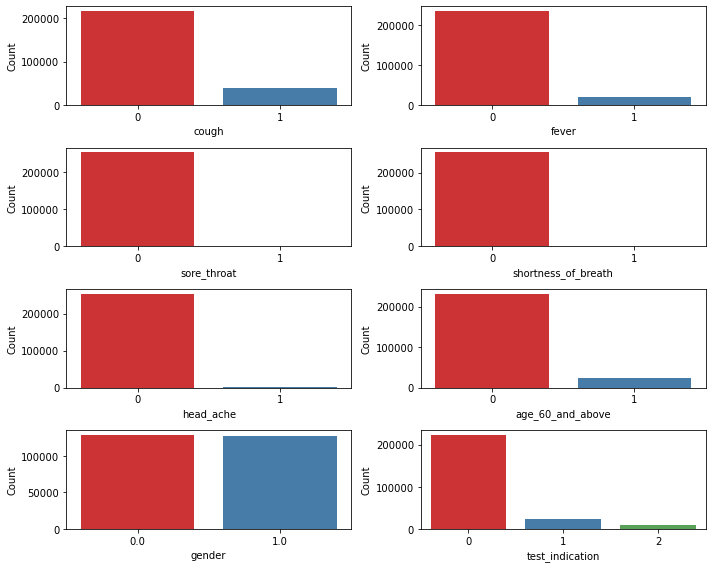

In [42]:
nrows = 4
ncols = 2
counter = 0
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,8))
for i in range(nrows):
    for j in range(ncols):
        group_df = df.groupby(feature_columns[counter])['corona_result'].count().reset_index().rename(columns={'corona_result': 'Count'})
        sns.barplot(data=group_df, x=feature_columns[counter], y='Count', ax=ax[i][j], palette='Set1')
        plt.tight_layout()
        counter = counter + 1
plt.show()

In [46]:
df_corona_result = df.groupby('corona_result')['cough'].count().reset_index().rename(columns={'cough': 'Count'})
df_corona_result

,corona_result,Count
0,0,242136
1,1,13532


<AxesSubplot:xlabel='corona_result', ylabel='Count'>

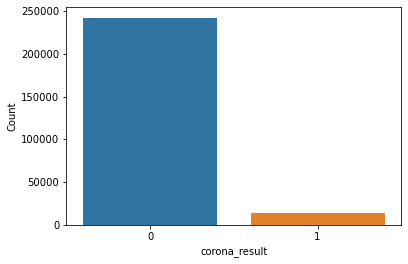

In [47]:
sns.barplot(x='corona_result', y='Count', data=df_corona_result)

### Corona Result wise feature counts 

### Cough

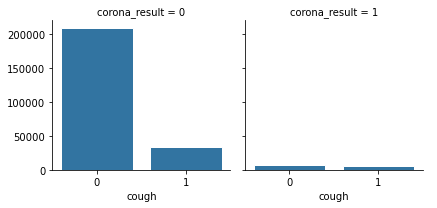

In [55]:
graph = sns.FacetGrid(df, col='corona_result')
graph.map(sns.countplot, 'cough', edgecolor ="w").add_legend()
plt.show()

### fever

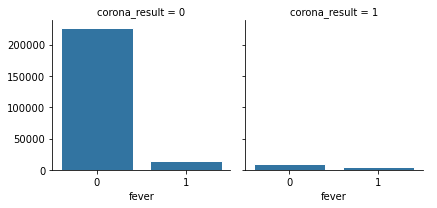

In [56]:
graph = sns.FacetGrid(df, col='corona_result')
graph.map(sns.countplot, 'fever', edgecolor ="w").add_legend()
plt.show()

### sore_throat

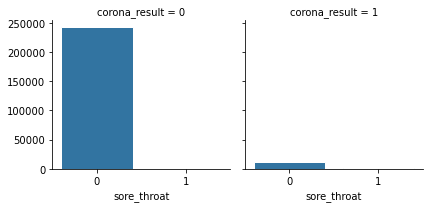

In [57]:
graph = sns.FacetGrid(df, col='corona_result')
graph.map(sns.countplot, 'sore_throat', edgecolor ="w").add_legend()
plt.show()

### shortness_of_breath

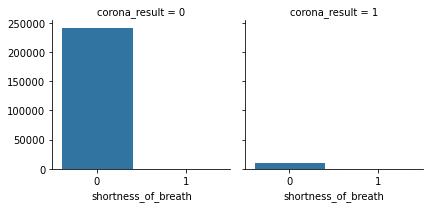

In [59]:
graph = sns.FacetGrid(df, col='corona_result')
graph.map(sns.countplot, 'shortness_of_breath', edgecolor ="w").add_legend()
plt.show()

### head_ache

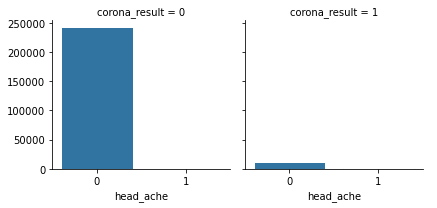

In [60]:
graph = sns.FacetGrid(df, col='corona_result')
graph.map(sns.countplot, 'head_ache', edgecolor ="w").add_legend()
plt.show()

### This plotting indicates that our data is imbalanced and need to perform some synthesizing before performing model

In [63]:
df.to_csv('Cleaned_covid_symptoms_prediction.csv')

In [64]:
# !pip install imbalanced-learn

In [65]:
features_columns  =  [x for x in df.columns.tolist() if x!='corona_result']
features_columns

['cough',
 'fever',
 'sore_throat',
 'shortness_of_breath',
 'head_ache',
 'age_60_and_above',
 'gender',
 'test_indication']

In [66]:
feature_values = df[features_columns].values.tolist()
target_values = df['corona_result'].values.tolist()

In [67]:
counter = Counter(target_values)
print(counter)

Counter({0: 242136, 1: 13532})


## Model Building for imbalanced data and checking accuracy

<p> The imbalanced-learn library supports random undersampling via the RandomUnderSampler class.

We can update the example to first oversample the minority class to have 10 percent the number of examples of the majority class (e.g. about 1,000), then use random undersampling to reduce the number of examples in the majority class to have 50 percent more than the minority class (e.g. about 2,000). </p>

### Performing SMTOE for imbalanced dataset

In [85]:
# over = SMOTE(sampling_strategy=0.1)
over = SMOTE()
# under = RandomUnderSampler(sampling_strategy=0.5)
# steps = [('o', over), ('u', under)]
steps = [('o', over)]
pipeline = Pipeline(steps=steps)

### transform the dataset

In [86]:
ub_feature_values, ub_target_values = pipeline.fit_resample(feature_values, target_values)

In [87]:
ub_counter = Counter(ub_target_values)
print(ub_counter)

Counter({0: 242136, 1: 242136})


### Building model with default max_depth value i.e. None

In [78]:
x_model = DecisionTreeClassifier()
x_over = SMOTE(sampling_strategy=0.1)
x_under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', x_over), ('under', x_under), ('model', x_model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, feature_values, target_values, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy Curve: %.3f' % mean(scores))

Mean Accuracy Curve: 0.950


In [88]:
x_model = DecisionTreeClassifier()
x_over = SMOTE()
x_under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', x_over), ('model', x_model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, feature_values, target_values, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy Curve: %.3f' % mean(scores))

Mean Accuracy Curve: 0.907


### evaluate decision tree performance on train and test sets with different tree depths

              precision    recall  f1-score   support

           0       0.80      0.99      0.89     14547
           1       0.96      0.51      0.66      7245

    accuracy                           0.83     21792
   macro avg       0.88      0.75      0.77     21792
weighted avg       0.85      0.83      0.81     21792

>1, train: 0.826, test: 0.829
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     14547
           1       0.83      0.71      0.77      7245

    accuracy                           0.86     21792
   macro avg       0.85      0.82      0.83     21792
weighted avg       0.86      0.86      0.85     21792

>2, train: 0.853, test: 0.857
              precision    recall  f1-score   support

           0       0.88      0.93      0.90     14547
           1       0.84      0.74      0.78      7245

    accuracy                           0.86     21792
   macro avg       0.86      0.83      0.84     21792
weighted avg  

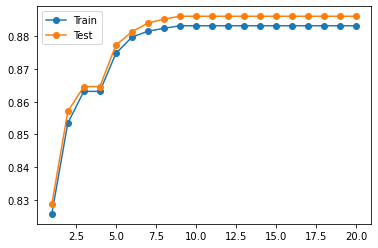

In [79]:
# # split into train test sets
# from sklearn.metrics import classification_report
# X_train, X_test, y_train, y_test = train_test_split(ub_feature_values, ub_target_values, test_size=0.3)
# # define lists to collect scores
# train_scores, test_scores = list(), list()
# # define the tree depths to evaluate
# values = [i for i in range(1, 21)]
# # evaluate a decision tree for each depth
# for i in values:
#     # configure the model
#     model = DecisionTreeClassifier(max_depth=i)
#     # fit model on the training dataset
#     model.fit(X_train, y_train)
#     # evaluate on the train dataset
#     train_yhat = model.predict(X_train)
#     train_acc = accuracy_score(y_train, train_yhat)
#     train_scores.append(train_acc)
#     # evaluate on the test dataset
#     test_yhat = model.predict(X_test)
#     test_acc = accuracy_score(y_test, test_yhat)
#     test_scores.append(test_acc)
#     print(classification_report(y_test, test_yhat))
#     # summarize progress
#     print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# # plot of train and test scores vs tree depth
# plt.plot(values, train_scores, '-o', label='Train')
# plt.plot(values, test_scores, '-o', label='Test')
# plt.legend()
# plt.show()

              precision    recall  f1-score   support

           0       0.67      0.99      0.80     72648
           1       0.98      0.50      0.67     72634

    accuracy                           0.75    145282
   macro avg       0.82      0.75      0.73    145282
weighted avg       0.82      0.75      0.73    145282

>1, train: 0.746, test: 0.746
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     72648
           1       0.91      0.71      0.80     72634

    accuracy                           0.82    145282
   macro avg       0.84      0.82      0.82    145282
weighted avg       0.84      0.82      0.82    145282

>2, train: 0.817, test: 0.818
              precision    recall  f1-score   support

           0       0.81      0.85      0.83     72648
           1       0.84      0.80      0.82     72634

    accuracy                           0.82    145282
   macro avg       0.82      0.82      0.82    145282
weighted avg  

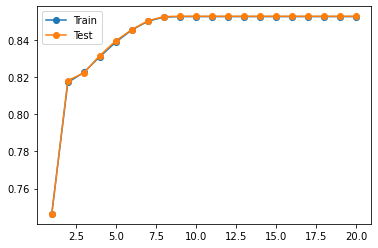

In [89]:
# split into train test sets
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(ub_feature_values, ub_target_values, test_size=0.3, random_state=42)
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the tree depths to evaluate
values = [i for i in range(1, 21)]
# evaluate a decision tree for each depth
for i in values:
    # configure the model
    model = DecisionTreeClassifier(max_depth=i)
    # fit model on the training dataset
    model.fit(X_train, y_train)
    # evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    print(classification_report(y_test, test_yhat))
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

### Building KNN model with default values

In [83]:
knn_model = KNeighborsClassifier()
knn_over = SMOTE(sampling_strategy=0.1)
knn_under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', knn_over), ('under', knn_under), ('model', knn_model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, feature_values, target_values, scoring='accuracy', cv=cv, n_jobs=-1)
print('Mean Accuracy Curve: %.3f' % mean(scores))

Mean Accuracy Curve: 0.959


### evaluate KNearestNeighbour performance on train and test sets with different number of neighbours

>1, train: 0.928, test: 0.928
              precision    recall  f1-score   support

           0       0.95      0.97      0.96     72680
           1       0.61      0.54      0.57      7225

    accuracy                           0.93     79905
   macro avg       0.78      0.75      0.77     79905
weighted avg       0.92      0.93      0.93     79905

>2, train: 0.940, test: 0.939
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     72680
           1       0.79      0.45      0.57      7225

    accuracy                           0.94     79905
   macro avg       0.87      0.72      0.77     79905
weighted avg       0.93      0.94      0.93     79905

>3, train: 0.950, test: 0.951
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     72680
           1       0.78      0.63      0.70      7225

    accuracy                           0.95     79905
   macro avg       0.87      0.80     

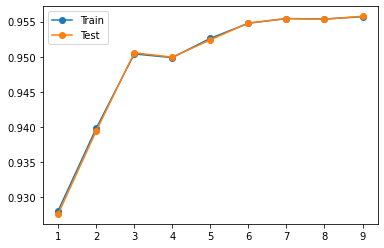

In [84]:
# split into train test sets
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test = train_test_split(ub_feature_values, ub_target_values, test_size=0.3)
# define lists to collect scores
train_scores, test_scores = list(), list()
# define the number of neighbour to evaluate
values = [i for i in range(1, 10)]
# evaluate a KNNeighbour tree for each depth
for i in values:
    # configure the model
    model = KNeighborsClassifier(n_neighbors=i)
    # fit model on the training dataset
    model.fit(X_train, y_train)
    # evaluate on the train dataset
    train_yhat = model.predict(X_train)
    train_acc = accuracy_score(y_train, train_yhat)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_yhat = model.predict(X_test)
    test_acc = accuracy_score(y_test, test_yhat)
    test_scores.append(test_acc)
    # summarize progress
    print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
    print(classification_report(y_test, test_yhat))
# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

### Final Model buidling

In [ ]:
# def predictModel(df):
#     features_columns  =  [x for x in df.columns.tolist() if x!='corona_result']
#     target_values = df['corona_result'].values.tolist()
#     counter = Counter(target_values)
#     print(counter)
#     over = SMOTE(sampling_strategy=0.1)
#     under = RandomUnderSampler(sampling_strategy=0.5)
#     steps = [('o', over), ('u', under)]
#     pipeline = Pipeline(steps=steps)
#     ub_feature_values, ub_target_values = pipeline.fit_resample(feature_values, target_values)
#     ub_counter = Counter(ub_target_values)
#     print(ub_counter)
#     model = DecisionTreeClassifier(max_depth=10)
#     # fit model on the training dataset
#     model_fit = model.fit(X_train, y_train)
#     return model_fit

In [90]:
def predictModel(df):
    features_columns  =  [x for x in df.columns.tolist() if x!='corona_result']
    target_values = df['corona_result'].values.tolist()
    counter = Counter(target_values)
    print(counter)
    over = SMOTE()
#     under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('o', over), ('u', under)]
    steps = [('o', over)]
    pipeline = Pipeline(steps=steps)
    ub_feature_values, ub_target_values = pipeline.fit_resample(feature_values, target_values)
    ub_counter = Counter(ub_target_values)
    print(ub_counter)
    model = DecisionTreeClassifier(max_depth=10)
    # fit model on the training dataset
    model_fit = model.fit(X_train, y_train)
    return model_fit

In [91]:
def predictSymptoms(model, symptoms_list):
    test_list = np.array([symptoms_list])
    prediction = model.predict(test_list)
    print(prediction)
    if prediction == 0:
        print('No covid')
    else:
        print('Covid symptoms are found, please isolate yourself and get yourself tested')

In [92]:
cleaned_df = pd.read_csv('Cleaned_covid_symptoms_prediction.csv')

In [93]:
df.columns.to_list()

['cough',
 'fever',
 'sore_throat',
 'shortness_of_breath',
 'head_ache',
 'corona_result',
 'age_60_and_above',
 'gender',
 'test_indication']

In [100]:
decisonTreeModel = predictModel(cleaned_df)
test_list = [1, 0, 0, 1, 0, 0, 0, 0]
predictSymptoms(decisonTreeModel, test_list)

Counter({0: 242136, 1: 13532})
Counter({0: 242136, 1: 242136})
[1]
Covid symptoms are found, please isolate yourself and get yourself tested
